## Minimal example from README.MD

C:\Users\s1522100\Documents\PhD Work\Python Scripts\Github\deepgpet\choseg\inference.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


[array([190, 290, 130]), 1.374898]

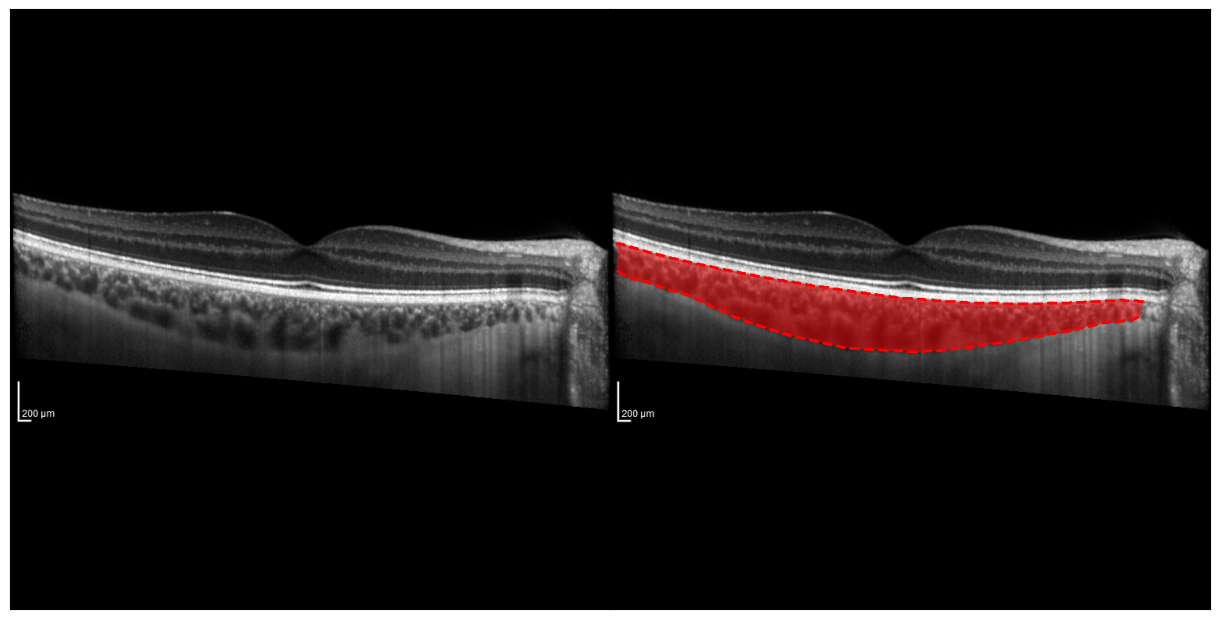

In [1]:
from choseg import inference, utils
from choseg.metrics import choroid_metrics

# Load model, default threshold of 0.5
deepgpet = inference.DeepGPET()

from pathlib import Path

# Load image

example_path = Path("notebooks/example_data")
img_path = example_path / "image1.png" #"path\to\img"
img = utils.load_img(img_path)

# Segment
img_seg = deepgpet(img)
img_seg_cmap = utils.generate_imgmask(img_seg,0.5,0) # Creates an RGBA colourmap to overlay segmentation onto image
img_trace = utils.get_trace(img_seg,0.5) # Detects the upper and lower choroid boundaries based on the mask
utils.plot_img(img, img_trace, cmap=img_seg_cmap, sidebyside=True) # Plots the image, trace and segmentation colour map

# Measure choroid thickness and area at default 3mm region of interest
choroid_metrics.compute_choroid_measurement(img_seg)
# thickness (temporal, subfoveal, nasal) (190, 290, 130), choroid area 1.374898mm2

---
# Inference

We can use DeepGPET to predicta single image using the call `deepgpet(img)` or `deepgpet.predict_img(img)`. In the second call, we can specify `soft_pred` to output the raw probability map before thresholding. By default, `soft_pred=False` so that the threshold is applied and we get a binary mask.

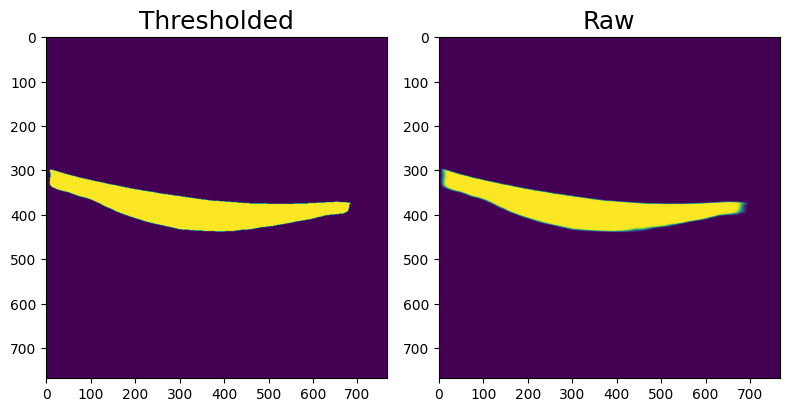

In [2]:
import matplotlib.pyplot as plt
img_seg = deepgpet(img)
img_seg_prob = deepgpet.predict_img(img, soft_pred=True)

fig, ax = plt.subplots(1,2,figsize=(8,5))
ax[0].imshow(img_seg)
ax[0].set_title("Thresholded", fontsize=18)
ax[1].imshow(img_seg_prob)
ax[1].set_title("Raw", fontsize=18)
fig.tight_layout()
plt.show()

We can also inference on a list of images, either specified by a list of file paths or a list of arrays

  0%|          | 0/3 [00:00<?, ?it/s]

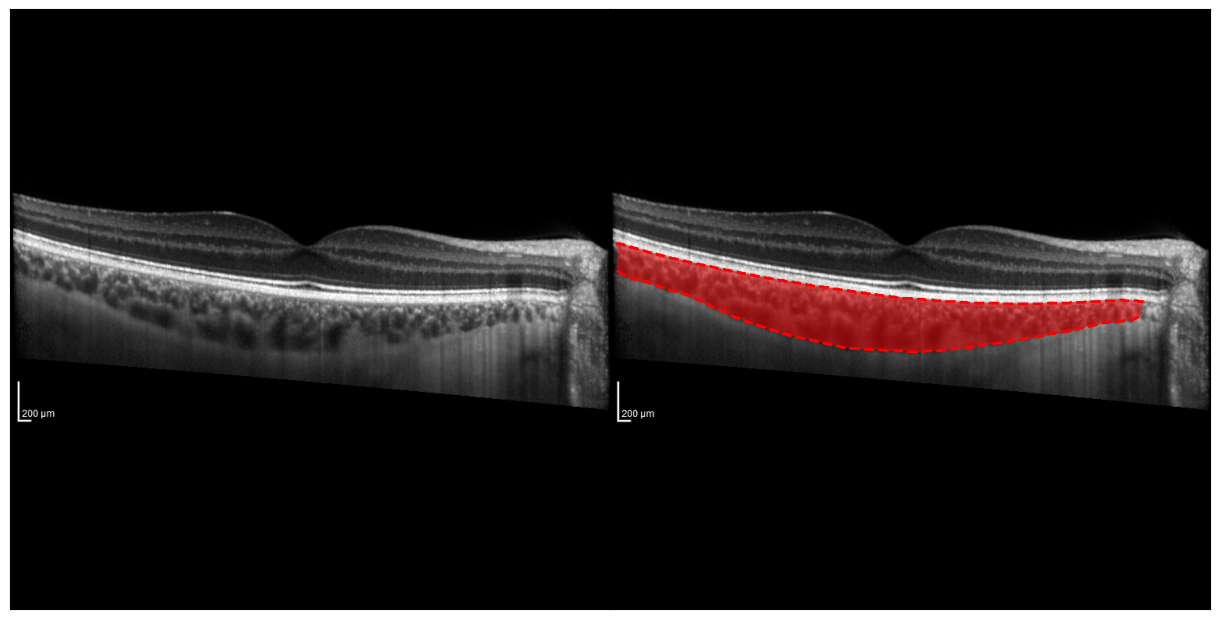

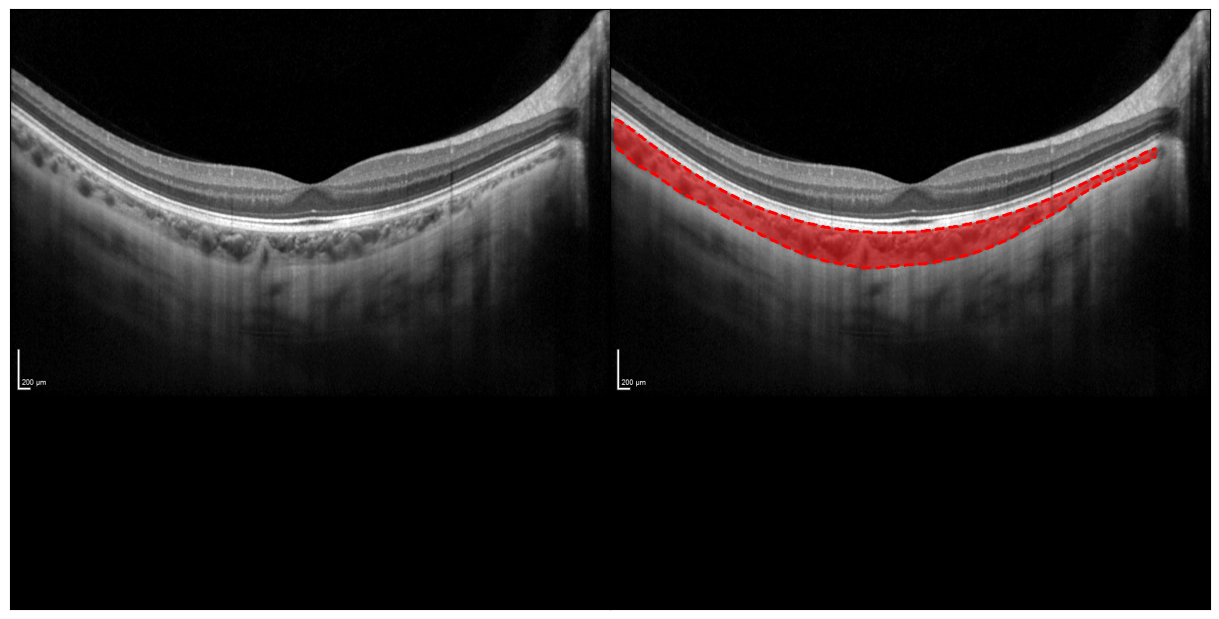

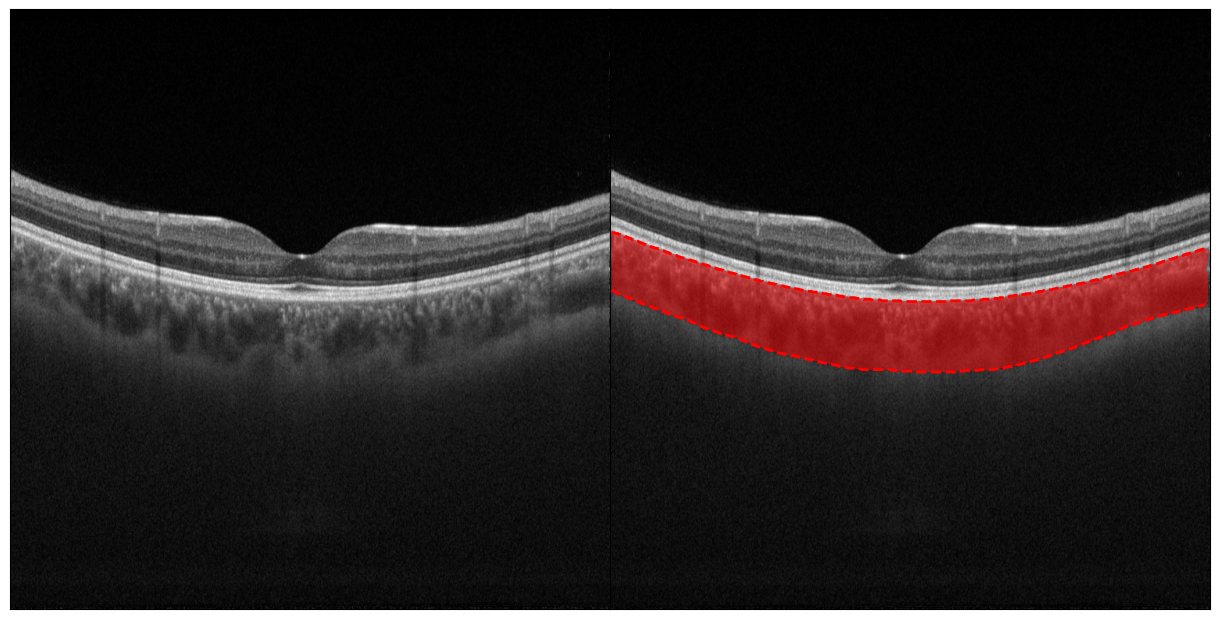

In [3]:
img_files = list(example_path.glob("*.png")) # detect any .png files in "notebooks/example_data/"
img_arrays = [utils.load_img(path) for path in img_files]

img_seg = deepgpet.predict_list(img_arrays) # or img_files

for img, seg in zip(img_arrays, img_seg):
    trace = utils.get_trace(seg)
    cmap = utils.generate_imgmask(seg)
    utils.plot_img(img, traces=trace, cmap=cmap, sidebyside=True)

---
# Measuring the choroid

To measure the choroid, there are a few inputs available to customise how and what you want to measure in the choroid. Note that the input `plottable` conveniently outputs a binary mask of the region of interest used to measure choroid area, and the points along the upper and lower bounds of the choroid segmentation which were used to measure choroid thickness. `plottable=False` only outputs the thickness and area values.

In [4]:
import pandas as pd
from choseg.metrics import choroid_utils

# Load image
img = utils.load_img(img_path)

# Segment
img_seg = deepgpet(img)

### Fovea
In our experience, knowing the location of the `fovea` in the OCT B-scan helps centre a region of interest on the scan and standardises the measurements you make, particularly if doing so across a cohort.


##### Selecting your own Fovea

If you do not know the location of the fovea, the function will take the midpoint of the segmentation and use that. This repository stores a simple, openCV-based GUI implementation for you to select the fovea for a series of images, check out `notebooks/demo_pixel_gui.ipynb`.

In [5]:
# It's only important to get the column index of the fovea, the row doesn't matter so much
# choroid_utils.select_pixels(img, scale=800, save_path="", fname=f"example_fovea", cmap=None)() # Uncomment this to use the simple GUI and overwrite example_fovea.csv with your own fovea!
fovea_path = r"example_fovea.csv"
fovea = pd.read_csv(fovea_path).values[0]

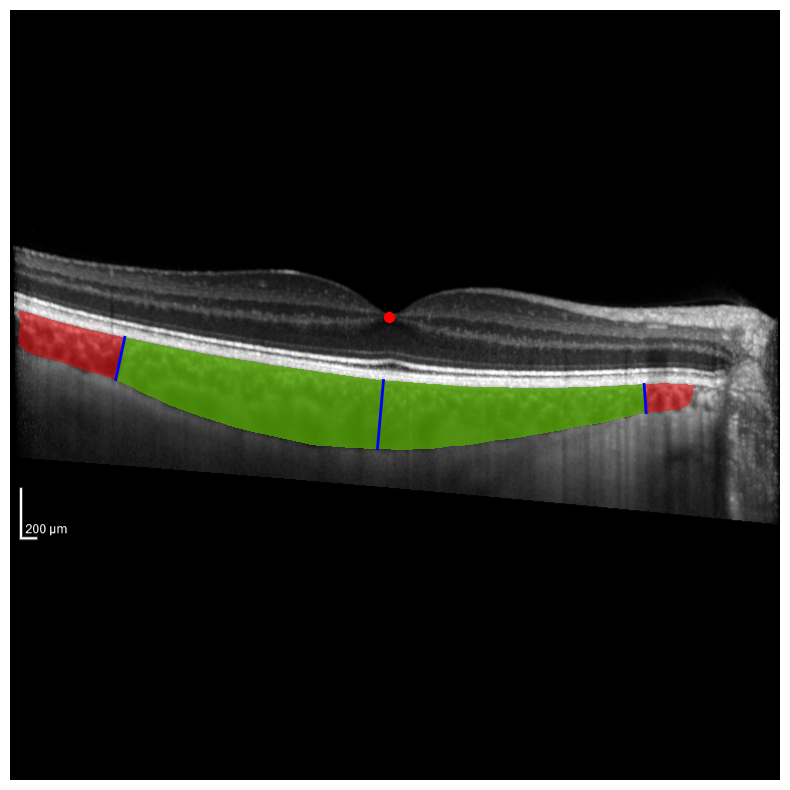

In [6]:
(ct, ca), (ct_pts, ca_mask) = choroid_metrics.compute_choroid_measurement(img_seg, fovea=fovea, plottable=True)
# thickness (193, 272, 111), area 1.357734mm2

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(img, cmap="gray")
ax.imshow(utils.generate_imgmask(img_seg,None,0), alpha=0.5) # segmentation mas (red)
ax.imshow(utils.generate_imgmask(ca_mask,None,1), alpha=0.5) # region of interest (green)
ax.scatter(fovea[0], fovea[1], s=50, color="r")
for i in range(ct_pts.shape[0]):
    ax.plot(ct_pts[i][0][:,0], ct_pts[i][0][:,1], c="b", linewidth=2) # thickness measurements
ax.set_axis_off()

### Scaling

OCT imaging devices provide an exact conversion factor from pixel space into physical space. This is typically in units microns-per-pixel. This changes depending on the size of the eye and degree of myopia. For an emmetropic individual, the Heidelberg imaging device default setting is `11.48 microns-per-pixel` in the `x` direction, and `3.87 microns-per-pixel` in the `y`-direction. This is coded as `scale=(11.48,3.87)`. 

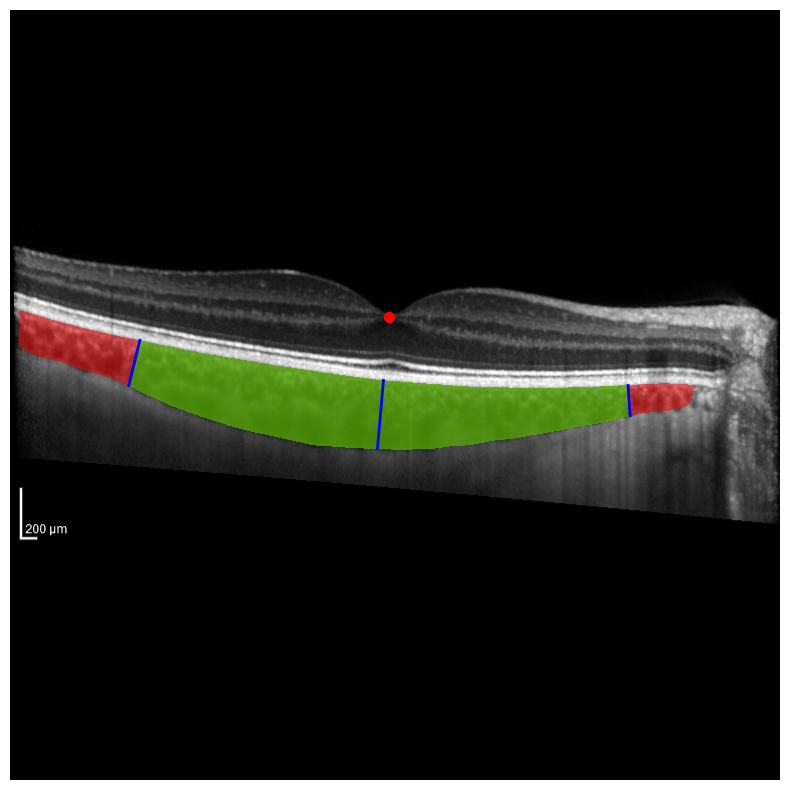

In [7]:
(ct, ca), (ct_pts, ca_mask) = choroid_metrics.compute_choroid_measurement(img_seg, fovea=fovea, scale=(12.24, 3.21), plottable=True) # set random scale for example
# thickness (197, 230,  99), area 1.154863mm2

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(img, cmap="gray")
ax.imshow(utils.generate_imgmask(img_seg,None,0), alpha=0.5) # segmentation mas (red)
ax.imshow(utils.generate_imgmask(ca_mask,None,1), alpha=0.5) # region of interest (green)
ax.scatter(fovea[0], fovea[1], s=50, color="r")
for i in range(ct_pts.shape[0]):
    ax.plot(ct_pts[i][0][:,0], ct_pts[i][0][:,1], c="b", linewidth=2) # thickness measurements
ax.set_axis_off()

### Region of interest

You can also specify the size of the region of interest using `macula_rum`, which represents the micron distance either side of the fovea.  By default `macula_rum=3000` microns, i.e. 3mm distance either side of the fovea, so a 6mm region of interest in total.

Moreover, on occasion the Choroid may appear skewed relative to the image axis, and so the region of interest is measured corresponding to the choroid axis by default to account for this curvature, and the measurements are made locally perpendicular to this axis. This can be changed to measure according to the image axis if preferred using `measure_type` and `measure_axis`. This means that choroid thickness is measured as a vertical line distance, and the region of interest is defined using the image axis, not the choroid axis.

The default setting here is `measure_type="perpendicular"` and `measure_axis=choroid`. In this case, the `offset` parameter is the number of pixel columns to define the tangential line around each location where the region of interest ends and measures thickness, so that a locally perpendicular line can be drawn.

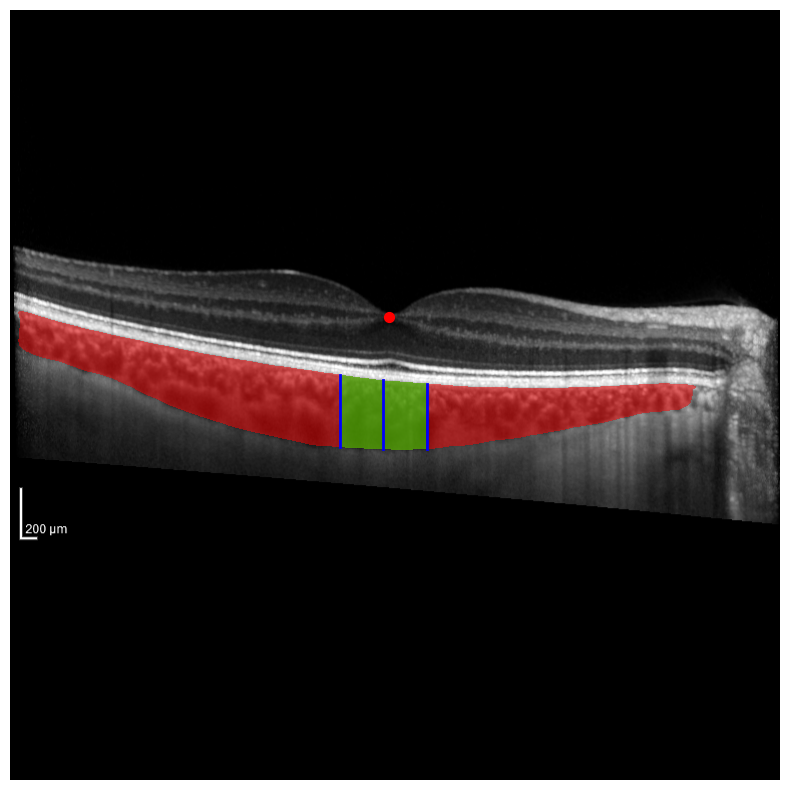

In [8]:
(ct, ca), (ct_pts, ca_mask) = choroid_metrics.compute_choroid_measurement(img_seg, fovea=fovea, scale=(11.48, 3.87), macula_rum=500, measure_type='vertical', measure_axis='image', plottable=True)
# thickness (275, 263, 248), area 0.264344mm2

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(img, cmap="gray")
ax.imshow(utils.generate_imgmask(img_seg,None,0), alpha=0.5) # region segmentation mask (red)
ax.imshow(utils.generate_imgmask(ca_mask,None,1), alpha=0.5) # region of interest (green)
ax.scatter(fovea[0], fovea[1], s=50, color="r")
for i in range(ct_pts.shape[0]):
    ax.plot(ct_pts[i][0][:,0], ct_pts[i][0][:,1], c="b", linewidth=2) # thickness measurements
ax.set_axis_off()

### Thickness measurements

You can also measure thickness values at several locations (and subfoveal by default) by specifying `N_measures`. Moreover, to robustly measure thickness you can use the `N_avgs` input to specify how many thickness measurements to be made at adjacent position for each locations.

For example, `N_measures=3` and `N_avgs=4` implies that we measure thickness at three locations, subfoveal and `macula_rum` microns temporal and nasal to the fovea. For each location, we measure thickness at the location, and at 2 columns either side of this point, and average the value.

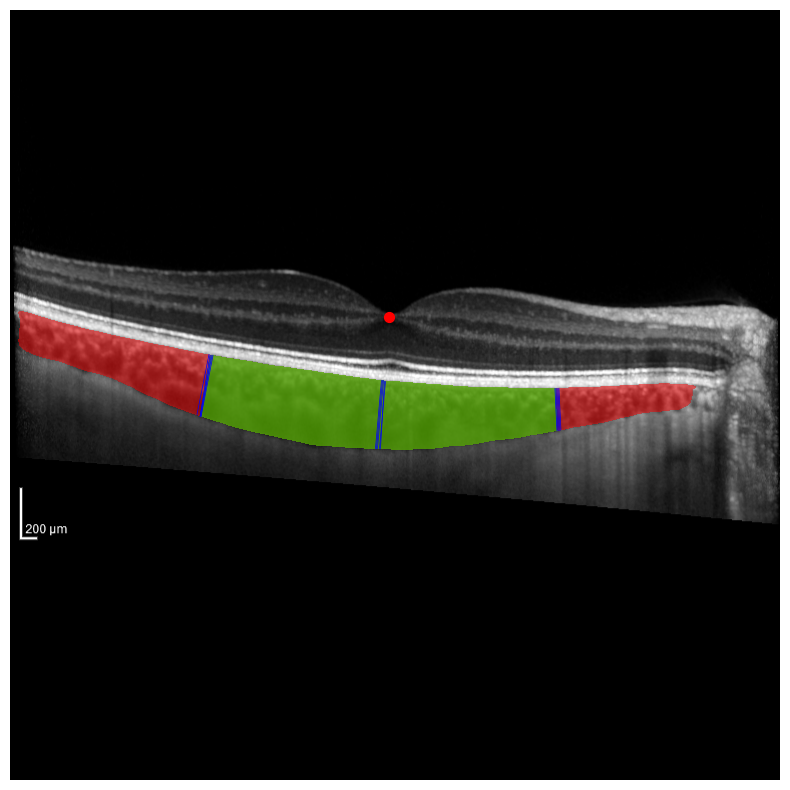

In [9]:
(ct, ca), (ct_pts, ca_mask) = choroid_metrics.compute_choroid_measurement(img_seg, fovea=fovea, scale=(11.48, 3.87), macula_rum=2000, N_measures=3, N_avgs=4,
                                                                          measure_type='perpendicular', measure_axis='choroid', plottable=True)
# thickness (268, 270, 163), area 1.003175mm2

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(img, cmap="gray")
ax.imshow(utils.generate_imgmask(img_seg,None,0), alpha=0.5) # region segmentation mask (red)
ax.imshow(utils.generate_imgmask(ca_mask,None,1), alpha=0.5) # region of interest (green)
ax.scatter(fovea[0], fovea[1], s=50, color="r")
for i in range(ct_pts.shape[0]):
    for j in range(ct_pts.shape[1]):
        ax.plot(ct_pts[i][j][:,0], ct_pts[i][j][:,1], c="b", linewidth=0.5) # thickness measurements
ax.set_axis_off()

## Robust measurement

Sometimes the segmentation might not be wide enough to measure the region of interst specified, i.e. if `macula_rum=8000`, i.e. 8mm either side of the fovea, this will not work and will output zeros. Setting `verbose=1` can warn the user of this.

Moreover, if your segmentation is unable to measure according to your input parameters, it will try it's best to accommodate them through setting `force_measurement=True`. 

In [10]:
choroid_metrics.compute_choroid_measurement(img_seg, fovea=fovea, scale=(11.48, 3.87), macula_rum=8000, N_measures=3, N_avgs=5,
                                                                          measure_type='perpendicular', measure_axis='choroid', plottable=True, verbose=1)
# thickness (0, 0, 0), area 0mm2, as it cannot measure this macula_rum

                    Extend segmentation or reduce macula_rum to prevent this from happening.
                    Returning 0s.


(array([0, 0, 0], dtype=int64), 0, 0)

            Reducing right-endpoint reference point by 8 pixels.
            Extend segmentation or reduce macula_rum/N_avgs/offset to prevent under-measurement.


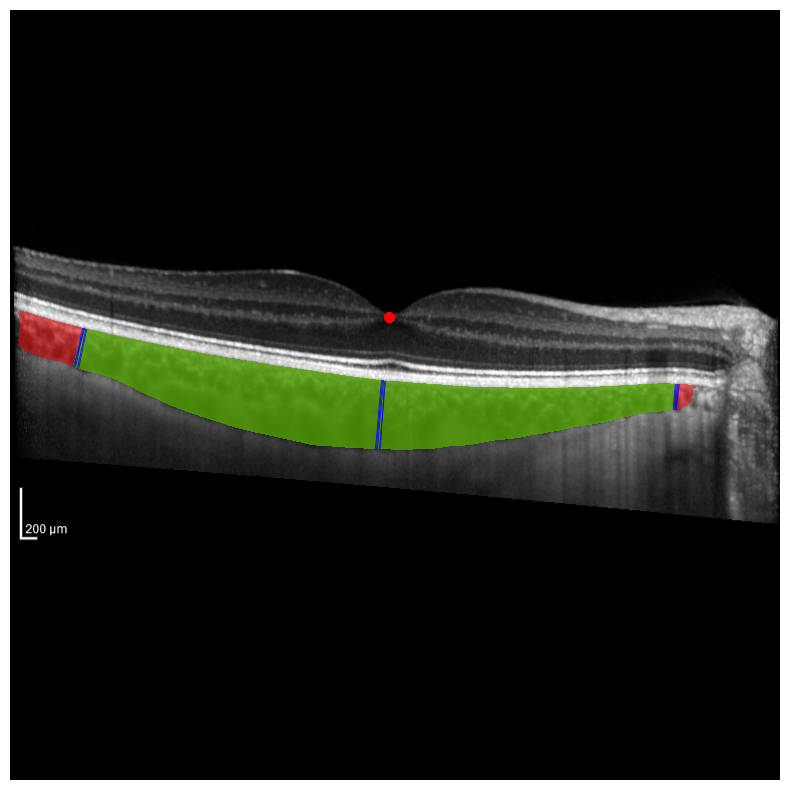

In [11]:
(ct, ca), (ct_pts, ca_mask) = choroid_metrics.compute_choroid_measurement(img_seg, fovea=fovea, scale=(11.48, 3.87), macula_rum=3465, N_measures=3, N_avgs=4,
                                                                          measure_type='perpendicular', measure_axis='choroid', plottable=True, verbose=1, force_measurement=True)
# thickness (177, 270, 100), area 1.472064mm2, as it cannot measure this macula_rum

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(img, cmap="gray")
ax.imshow(utils.generate_imgmask(img_seg,None,0), alpha=0.5) # region segmentation mask (red)
ax.imshow(utils.generate_imgmask(ca_mask,None,1), alpha=0.5) # region of interest (green)
ax.scatter(fovea[0], fovea[1], s=50, color="r")
for i in range(ct_pts.shape[0]):
    for j in range(ct_pts.shape[1]):
        ax.plot(ct_pts[i][j][:,0], ct_pts[i][j][:,1], c="b", linewidth=0.5) # thickness measurements
ax.set_axis_off()

---
## Putting it all together

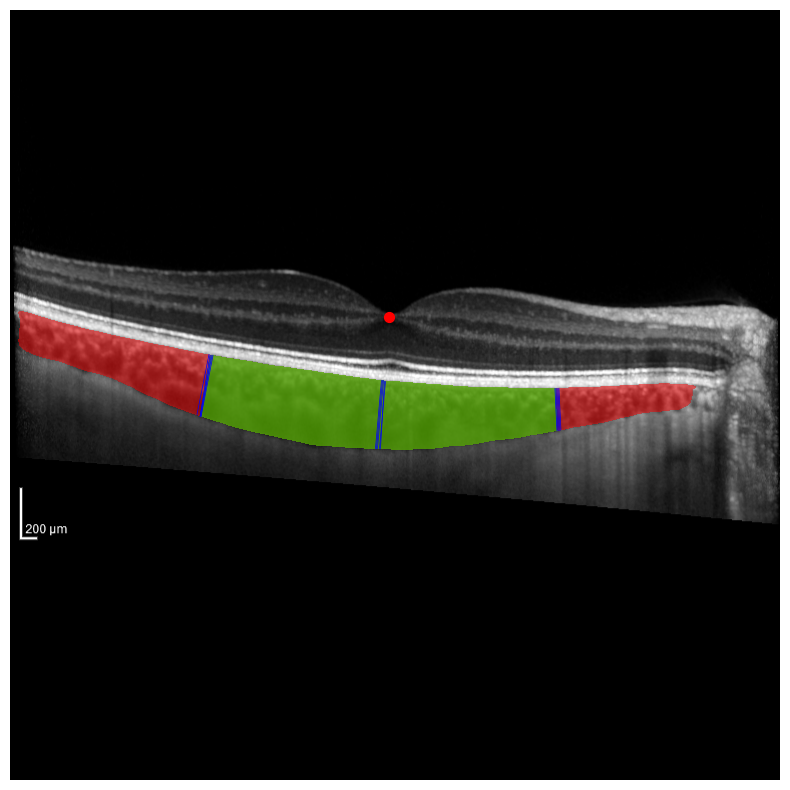

In [12]:
(ct, ca), (ct_pts, ca_mask) = choroid_metrics.compute_choroid_measurement(img_seg, 
                                                                          fovea=fovea, 
                                                                          scale=(11.48, 3.87), 
                                                                          macula_rum=2000, 
                                                                          N_measures=3, 
                                                                          N_avgs=4,
                                                                          offset=15,
                                                                          measure_type='perpendicular', 
                                                                          measure_axis='choroid',
                                                                          plottable=True, 
                                                                          verbose=0, 
                                                                          force_measurement=False)
# thickness (268, 270, 163), area 1.003175mm2, as it cannot measure this macula_rum

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(img, cmap="gray")
ax.imshow(utils.generate_imgmask(img_seg,None,0), alpha=0.5) # region segmentation mask (red)
ax.imshow(utils.generate_imgmask(ca_mask,None,1), alpha=0.5) # region of interest (green)
ax.scatter(fovea[0], fovea[1], s=50, color="r")
for i in range(ct_pts.shape[0]):
    for j in range(ct_pts.shape[1]):
        ax.plot(ct_pts[i][j][:,0], ct_pts[i][j][:,1], c="b", linewidth=0.5) # thickness measurements
ax.set_axis_off()